In [1]:
# Useful imports and setup
import sys
import os
# Necessary to import code from ../scripts/
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path+"/scripts")
    
import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
import numpy as np
import pandas as pd
import glob
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from copy import copy
from sklearn.decomposition import PCA

from preprocessing import preprocess
from gating import *
from visualization import *

from matplotlib import rc 

data_path = '../data/'

rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)
rc('text.latex', preamble=r'\usepackage{amsmath}\usepackage{amssymb}')


In [2]:
def get_feature_activations(norm, sparsity, percentile, X, x_train):
   
    meta = {'gumbel_temp': 1, 'gumbel_noise': 1e-8}
    model = MaskingModel(n_groups=x_train.shape[-1])

    filename = 'annealing_fg_'+norm+'_norm_'+str(sparsity)+'_perc_'+str(percentile)
    model.load_weights(MODEL_PATH + filename).expect_partial()

    masks = model.get_mask(X, meta)

    f_activated = tf.reduce_sum(masks, axis=0)
    f_activations = [(feature_names[i], f_activated[i].numpy()) for i in tf.where(f_activated)[:, 0]]
    
    return f_activations, masks

def get_cluster_features(labels, masks, feature_names, X, Y):
    
    clusters = {}
    for c in range(np.max(labels)+1):
        cluster = np.where(labels == c)[0]
        clusters[c] = {}
        clusters[c]['total_number_students'] = len(cluster)
        
        y_cluster = tf.gather(Y, list(cluster)).numpy()
        clusters[c]['total_number_pass_students'] = (y_cluster == 0).sum()
        clusters[c]['total_number_fail_students'] = (y_cluster == 1).sum()
        
        f_activated = tf.reduce_sum(tf.gather(masks, list(cluster)), axis=0)
        
        clusters[c]['features'] = {}
        for i in tf.where(f_activated)[:, 0]:
            # Select the indices that belong to the actual cluster and have feature 'i' activated
            a = np.where(masks[:, i] == 1)[0]
            a = list(set(a) & set(list(cluster))) 
            
            # Split the selected indices between pass/fail students
            target_0 = [j for j in a if Y[j] == 0]
            target_1 = [j for j in a if Y[j] == 1]
            
            clusters[c]['features'][feature_names[i]] = {}
            clusters[c]['features'][feature_names[i]]['number_students'] = f_activated[i].numpy()
            clusters[c]['features'][feature_names[i]]['avg_value'] = tf.reduce_mean(X[a, :, i]).numpy()
            clusters[c]['features'][feature_names[i]]['relative_value'] = tf.reduce_mean(X[a, :, i]).numpy()-tf.reduce_mean(X[:, :, i]).numpy()
            
            clusters[c]['features'][feature_names[i]]['number_pass_students'] = len(target_0)
            clusters[c]['features'][feature_names[i]]['avg_pass_value'] = tf.reduce_mean(X[target_0, :, i]).numpy()
            clusters[c]['features'][feature_names[i]]['relative_pass_value'] = tf.reduce_mean(X[target_0, :, i]).numpy()-tf.reduce_mean(X[:, :, i]).numpy()
            clusters[c]['features'][feature_names[i]]['number_fail_students'] = len(target_1)
            clusters[c]['features'][feature_names[i]]['avg_fail_value'] = tf.reduce_mean(X[target_1, :, i]).numpy()
            clusters[c]['features'][feature_names[i]]['relative_fail_value'] = tf.reduce_mean(X[target_1, :, i]).numpy()-tf.reduce_mean(X[:, :, i]).numpy()
            
    return clusters

The code below creates a table with all the information about clustering and the selected features for all configurations of normalization and sparsity targets tested using the first 4 weeks of each course.

In [ ]:
percentile = 0.4
data_path = '../data/'
feature_types = ['lalle_conati', 'boroujeni_et_al', 'chen_cui', 'marras_et_al']
metadata = pd.read_csv(data_path + 'metadata.csv')
df = {}
df['course'] = []
df['number_students'] = []
df['norm'] = []
df['sparsity'] = []
df['max_features'] = []
df['average_features'] = []
df['features_for_all_students'] = []
df['train_bal_acc'] = []
df['val_bal_acc'] = []
df['test_bal_acc'] = []
df['f_activations'] = []
df['number_clusters'] = []
df['silhouette_score'] = []
df['clusters_labels'] = []
df['clusters_dict'] = []

for course in courses:
    results_path = '../results/' + course + '/inter-c3/'
    MODEL_PATH = '../models/saved/' + course + '/'
    path = data_path + course + '/'
    print(course)
    
    try:
        clusters = pd.read_pickle(results_path+'clusters_info.pkl')  
        
    except:
        continue
    
    norm_sparsity = {}
    norm_sparsity['unit'] = []
    norm_sparsity['min-max'] = []
    for f in glob.glob(MODEL_PATH+'*.index'):
        f = f.replace(MODEL_PATH, '').replace('.index', '').replace('annealing_fg_', '')
        f = f.split('_')
        if f[0] == 'unit' or f[0] == 'min-max':
            norm_sparsity[f[0]].append(float(f[2]))
    
    norm_sparsity['unit'].sort()
    norm_sparsity['min-max'].sort()
    
    for norm in norm_sparsity.keys():
        x_train, x_test, x_val, y_train, y_test, y_val, feature_names = preprocess(course, path, percentile, 
                                                                                   feature_types, metadata, 
                                                                                   normalization=norm)
        X = np.concatenate([x_train, x_val, x_test], axis=0)
        Y = np.concatenate([y_train, y_val, y_test], axis=0)
        
        clusters_per_norm = clusters[clusters['norm'] == norm]
        for sparsity in np.unique(norm_sparsity[norm]):
            
            clusters_per_sparsity = clusters_per_norm[clusters_per_norm['sparsity'] == sparsity]
            if len(clusters_per_sparsity) == 0:
                continue
                
            clusters_per_sparsity = clusters_per_sparsity.reset_index()
            
            f_activations, masks = get_feature_activations(norm, sparsity, percentile, X, x_train)
            
            df['course'].append(course)
            df['number_students'].append(X.shape[0])
            df['norm'].append(norm)
            df['sparsity'].append(sparsity)
            df['max_features'].append(len(f_activations))
            df['average_features'].append(np.mean(tf.reduce_sum(masks, axis=1).numpy()))
            count = 0
            for f, a in f_activations:
                if a/X.shape[0] == 1:
                    count += 1
            df['features_for_all_students'].append(count)
            
            try: 
                scores = np.load(results_path+'scores_'+norm+'_norm_'+str(sparsity)+'.npy',allow_pickle='TRUE').item()
            except:
                scores = np.load(results_path+'scores_'+norm+'_norm_'+str(sparsity)+'_perc_'+str(percentile)+'.npy',allow_pickle='TRUE').item()
            df['train_bal_acc'].append(scores['train_bal_acc'][-1].numpy())
            df['val_bal_acc'].append(scores['val_bal_acc'][-1].numpy())
            
            test_acc = np.load(results_path+'test_acc_'+norm+'_norm_'+str(sparsity)+'.npy',allow_pickle='TRUE').item()
            df['test_bal_acc'].append(test_acc)
            
            df['f_activations'].append(f_activations)
            df['number_clusters'].append(clusters_per_sparsity['number_clusters'].tolist()[0])
            df['silhouette_score'].append(clusters_per_sparsity['silhouette_score'].tolist()[0])
            df['clusters_labels'].append(clusters_per_sparsity['labels'][0])

            df['clusters_dict'].append(get_cluster_features(clusters_per_sparsity['labels'][0], masks, 
                                                    feature_names, X, Y))
            


In [ ]:
df = pd.DataFrame(df)
pd.to_pickle(df, '../results/final_results.pkl') 

In [3]:
df = pd.read_pickle('../results/final_results.pkl')

In [4]:
best_unit = {}
best_unit['analysenumerique_002'] = 0.58
best_unit['analysenumerique_003'] = 0.58
best_unit['cpp_fr_001'] = 0.6
best_unit['initprogcpp_001'] = 0.6
best_unit['dsp_001'] = 0.5
best_unit['dsp_002'] = 0.5
best_unit['dsp_004'] = 0.56
best_unit['dsp_005'] = 0.5
best_unit['dsp_006'] = 0.55
best_unit['geomatique_003'] = 0.6
best_unit['hwts_001'] = 0.5
best_unit['hwts_002'] = 0.6
best_unit['microcontroleurs_003'] = 0.6
best_unit['microcontroleurs_004'] = 0.5
best_unit['microcontroleurs_005'] = 0.55
best_unit['microcontroleurs_006'] = 0.55
best_unit['progfun_002'] = 0.5
best_unit['venture_001'] = 0.55
best_unit['villesafricaines_001'] = 0.5
best_unit['villesafricaines_002'] = 0.5
best_unit['villesafricaines_003'] = 0.5

In [5]:
# Best sparsity criteria for min-max norm:

# best = {}
# best['analysenumerique_002'] = 0.54
# best['analysenumerique_003'] = 0.57 
# best['cpp_fr_001'] = 0.6
# best['dsp_001'] = 0.43
# best['dsp_002'] = 0.5
# best['dsp_004'] = 0.5
# best['dsp_005'] = 0.5
# best['dsp_006'] = 0.5
# best['geomatique_003'] = 0.6
# best['hwts_001'] = 0.55
# best['hwts_002'] = 0.54
# best['initprogcpp_001'] = 0.58
# best['microcontroleurs_003'] = 0.56
# best['microcontroleurs_004'] = 0.45
# best['microcontroleurs_005'] = 0.5
# best['microcontroleurs_006'] = 0.55
# best['progfun_002'] = 0.45
# best['venture_001'] = 0.55
# best['villesafricaines_001'] = 0.5
# best['villesafricaines_002'] = 0.5
# best['villesafricaines_003'] = 0.5

In [6]:
df_selected = pd.DataFrame()
for i, (course, sparsity) in enumerate(zip(best_unit, best_unit.values())):
    c = df[df['course'] == course]
    c = c[c['norm'] == 'unit']
    c = c[c['sparsity'] == sparsity]

    c = c.reset_index()
    df_selected = pd.concat([df_selected, c])

In [7]:
def get_cluster_with_more_fail(x):
    proportion_fail = 0 
    idx_cluster = -1
        
    for cluster in x.keys():
        p = x[cluster]['total_number_fail_students']/x[cluster]['total_number_pass_students']
        
        if p > proportion_fail:
            proportion_fail = p
            idx_cluster = cluster
            
    return idx_cluster

def get_cluster_with_more_pass(x):
    proportion_pass = 0
    idx_cluster = -1
        
    for cluster in x.keys():
        p = x[cluster]['total_number_pass_students']/x[cluster]['total_number_fail_students']
        
        if p > proportion_pass:
            proportion_pass = p
            idx_cluster = cluster
            
    return idx_cluster

def get_cluster_more_balanced(x):
    diff = sys.maxsize
    idx_cluster = -1
        
    for cluster in x.keys():
        p = x[cluster]['total_number_pass_students'] - x[cluster]['total_number_fail_students']
        
        if np.abs(p) < diff :
            diff = np.abs(p)
            idx_cluster = cluster
            
    return idx_cluster
            
def get_feature_importance_per_type(cluster_type):
    df_importance = pd.DataFrame()
    i = 0
    save_cluster = []
    for course in df_selected['course']:
        x = df_selected[df_selected['course'] == course]
        x = x['clusters_dict'][0]
        
        if cluster_type == 'fail':
            idx_cluster = get_cluster_with_more_fail(x)
        elif cluster_type == 'pass':
            idx_cluster = get_cluster_with_more_pass(x)
        elif cluster_type == 'balanced':
            idx_cluster = get_cluster_more_balanced(x)
        
        feature_importance = {}
        save_cluster.append(idx_cluster)
        n = x[idx_cluster]['total_number_students']
        for f in x[idx_cluster]['features'].keys():
            feature_importance[f] = x[idx_cluster]['features'][f]['number_students']/n
        aux = pd.DataFrame(feature_importance, index=[i])
        df_importance = pd.concat([df_importance, aux])
        i += 1
    
    return df_importance, save_cluster

def get_feature_importance_all_clusters():
    # compute df with the feature importance for all clusters overall courses
    # return also the metadata
    labels_in_order = []
    feature_importance = {}
    df_importance = pd.DataFrame()
    fields_in_order = []
    lang_in_order = []
    i = 0
    for course in df_selected['course']:
        x = df_selected[df_selected['course'] == course]
        x = x['clusters_dict'][0]

        for idx_cluster in x:
            feature_importance = {}
            labels_in_order.append(dict_course_names[course])
            fields_in_order.append(topics_course[course])
            lang_in_order.append(language_and_level_course[course])
            n = x[idx_cluster]['total_number_students']
            for f in x[idx_cluster]['features'].keys():
                feature_importance[f] = x[idx_cluster]['features'][f]['number_students']/n
            aux = pd.DataFrame(feature_importance, index=[i])
            df_importance = pd.concat([df_importance, aux])
            i += 1
            
    return df_importance, labels_in_order, fields_in_order, lang_in_order

df_balanced, clusters_balanced = get_feature_importance_per_type('balanced')
df_fail, clusters_fail = get_feature_importance_per_type('fail')
df_pass, clusters_pass = get_feature_importance_per_type('pass')

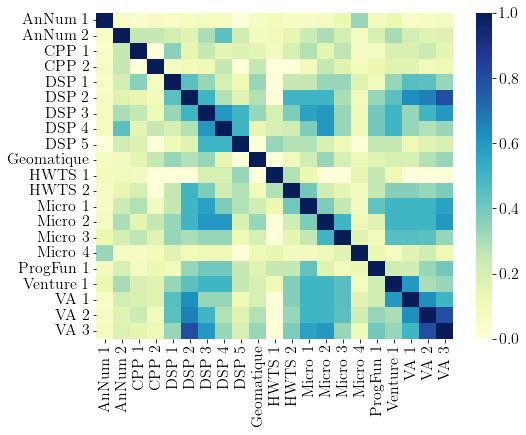

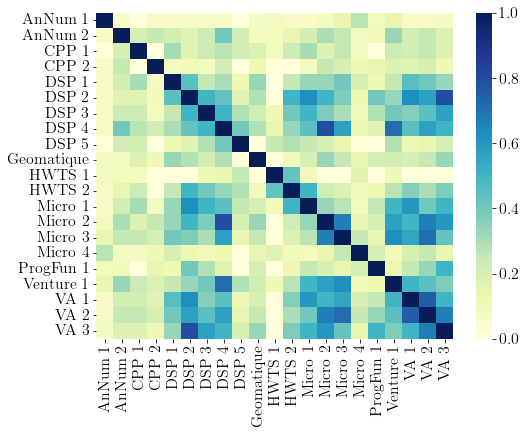

In [8]:
d_fail = get_jaccard_plot(df_fail, [dict_course_names[i] for i in best_unit.keys()], "../images/unit/over_all_worst_jaccard.jpeg")
d_pass = get_jaccard_plot(df_pass, [dict_course_names[i] for i in best_unit.keys()], "../images/unit/over_all_best_jaccard.jpeg")

### Worst-performing students

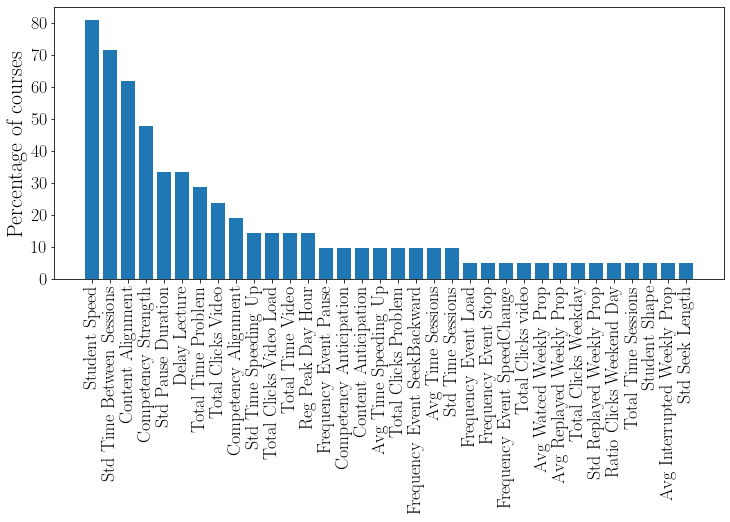

In [9]:
order_feats, feats_fail = percentage_courses_per_feature(df_fail)

### Best-performing students

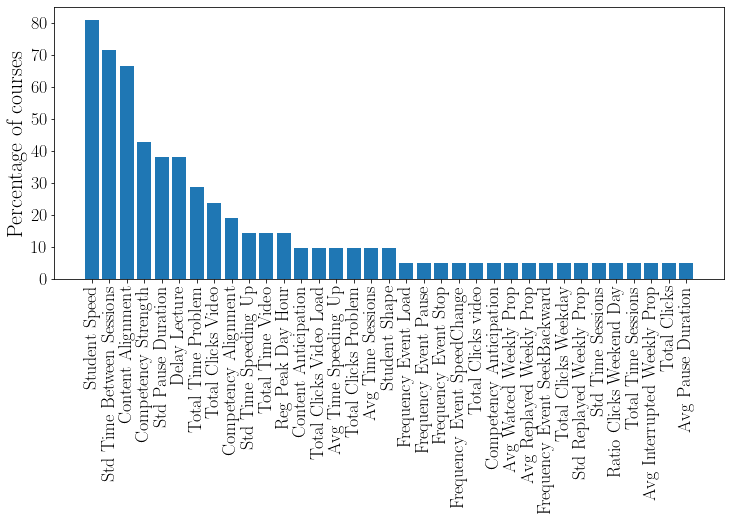

In [10]:
order_feats, feats_pass = percentage_courses_per_feature(df_pass)

### Difference

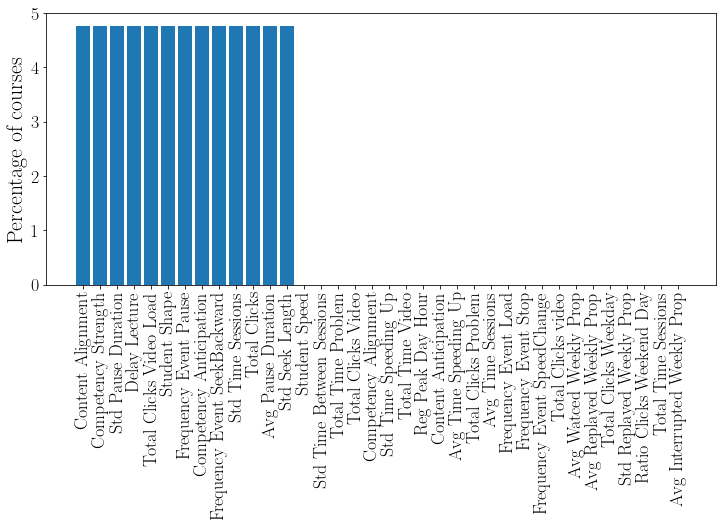

In [11]:
diff = {}
for f, v in feats_pass.items():
    try:
        diff[f] = abs(v - feats_fail[f])
    except:
        diff[f] = v

for f in feats_fail:
    try:
        if diff[f] > 0:
            continue
    except:
        diff[f] = feats_fail[f]
        
diff = dict(sorted(diff.items(), key=operator.itemgetter(1), reverse=True))

index = list(diff.keys()) 

newList = [x / 21 * 100 for x in list(diff.values())]

plt.figure(figsize=(12, 5))
plt.bar(index, newList)

plt.yticks(fontsize=18)
plt.ylabel('Percentage of courses', fontsize=22)
plt.xticks(index, rotation=90, ha='center', fontsize=18)
plt.show()

### Overall clusters

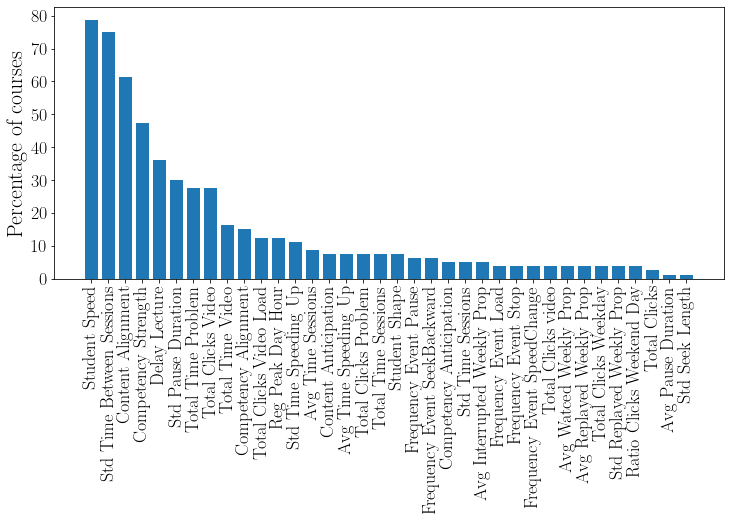

In [12]:
df_importance, labels_in_order, fields_in_order, lang_in_order = get_feature_importance_all_clusters()
order_feats, feats = percentage_courses_per_feature(df_importance)

In [13]:
def get_features_per_course(type_):
    
    features_per_course = {}

    for course in df_selected['course']:
        features_per_course[course] = {}
        x = df_selected[df_selected['course'] == course]
        x = x['clusters_dict'][0]
        
        if type_ == 'fail':
            idx_cluster = get_cluster_with_more_fail(x)
        elif type_ == 'pass':
            idx_cluster = get_cluster_with_more_pass(x)

        n = x[idx_cluster]['total_number_students']
        for f in x[idx_cluster]['features']:
            try:
                features_per_course[course][feature_names_dict[f]] += x[idx_cluster]['features'][f]['number_students']/n
            except:
                features_per_course[course][feature_names_dict[f]] = x[idx_cluster]['features'][f]['number_students']/n
    
    return features_per_course

features_per_course_f =  get_features_per_course('fail')
features_per_course_p =  get_features_per_course('pass')

In [14]:
features_per_course = {}

for course in df_selected['course']:
    features_per_course[course] = {}
    
    feats = list(set(list(features_per_course_p[course].keys()) + list(features_per_course_f[course].keys())))
    for f in feats: 
        try: 
            features_per_course[course][f] = features_per_course_p[course][f] - features_per_course_f[course][f]
        except:
            try:
                features_per_course[course][f] = features_per_course_p[course][f]
            except:
                features_per_course[course][f] = -features_per_course_f[course][f]

### Features diferrence (best - worst)  

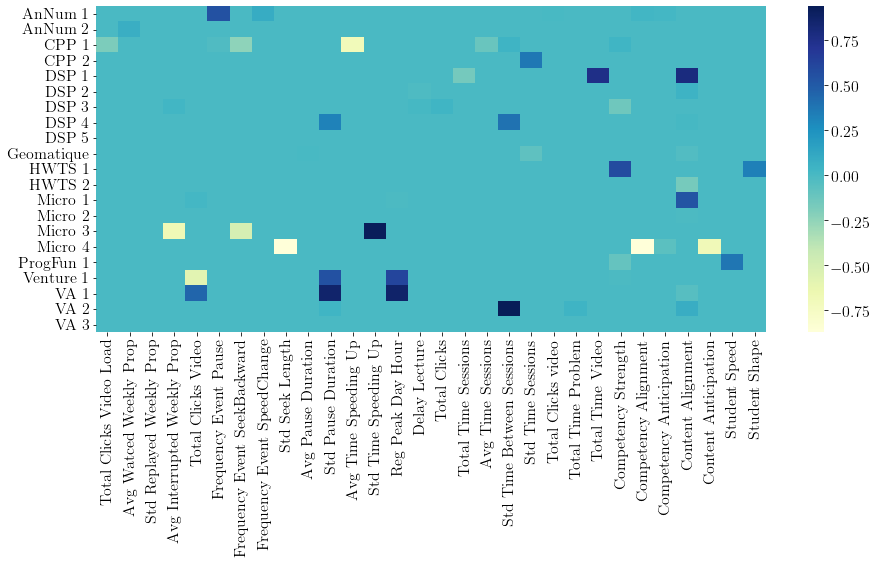

In [15]:
zero_data = np.zeros(shape=(21, 45))
cols = list(feature_names_dict.values())
d = pd.DataFrame(zero_data, columns=cols)

for i, course in enumerate(features_per_course):
    for j, f in enumerate(feature_names_dict.values()):
        try:
            d[f][i] = features_per_course[course][f]
        except:
            continue
drops = []
for c in d.columns:
    if (d[c] == 0).all():
        drops.append(c)
d = d.drop(drops, axis=1)

my_cmap = copy(plt.cm.YlGnBu)
my_cmap.set_over("white")
my_cmap.set_under("white")

fig, ax = plt.subplots(figsize=(15, 6),facecolor='white')
g = sns.heatmap(d, cmap=my_cmap)
g.xaxis.get_label().set_fontsize(16)
g.yaxis.get_label().set_fontsize(16)
g.set_xticklabels(d.columns,rotation=90, fontsize=16)
g.set_yticklabels([dict_course_names[i] for i in best_unit.keys()], rotation=0, fontsize=16)

cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=16)

plt.show()

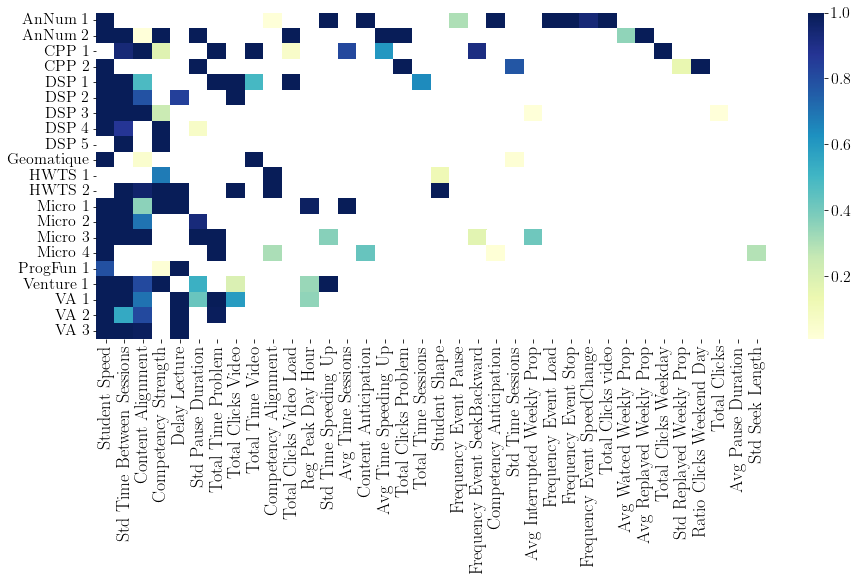

In [16]:
def get_all_features_per_course(f_name, index=None):
    
    if index == None:
        index = list(feature_names_dict.values())
    elif len(index) < len(feature_names_dict.values()):
        index += list((set(list(feature_names_dict.values())) - set(index)))

    zero_data = np.zeros(shape=(21, 45))
    d = pd.DataFrame(zero_data, columns=index)
    
    features_per_course = {}
                         
    for course in df_selected['course']:
        features_per_course[course] = {}
        x = df_selected[df_selected['course'] == course]
        x = x['clusters_dict'][0]
        
        for idx_cluster in x:
            n = x[idx_cluster]['total_number_students']
            for f in x[idx_cluster]['features']:
                try:
                    features_per_course[course][feature_names_dict[f]] += x[idx_cluster]['features'][f]['number_students']/n
                except:
                    features_per_course[course][feature_names_dict[f]] = x[idx_cluster]['features'][f]['number_students']/n

        for f in features_per_course[course]:
            features_per_course[course][f] /= len(x)
        
    for i, course in enumerate(features_per_course):
        for j, f in enumerate(index):
            try:
                d[f][i] = features_per_course[course][f]
            except:
                continue
    drops = []
    for c in d.columns:
        if (d[c] == 0).all():
            drops.append(c)
    d = d.drop(drops, axis=1)
    
    my_cmap = copy(plt.cm.YlGnBu)
    my_cmap.set_over("white")
    my_cmap.set_under("white")
    
    fig, ax = plt.subplots(figsize=(15, 6),facecolor='white')
    g = sns.heatmap(d,vmin=0.01, fmt=".2f", cmap=my_cmap)
    g.xaxis.get_label().set_fontsize(18)
    g.yaxis.get_label().set_fontsize(18)
    g.set_xticklabels(d.columns,rotation=90, fontsize=18)
    g.set_yticklabels([dict_course_names[i] for i in best_unit.keys()], rotation=0, fontsize=16)
    
    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=16)
    
    plt.savefig(f_name, bbox_inches='tight')
    plt.show()
    
    return d
    
d = get_all_features_per_course('../images/new/features-all-courses.pdf', order_feats)

### Spearman's correlation
1. Overall
2. Worst-performins students
3. Best-performing students

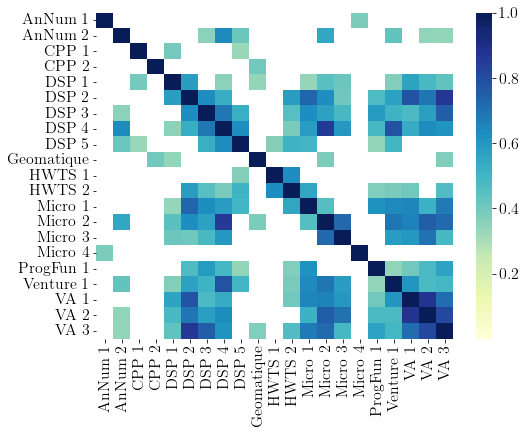

In [17]:
_ = get_spearmans_plot(d, [dict_course_names[i] for i in best_unit.keys()], "../images/unit/overall.pdf")

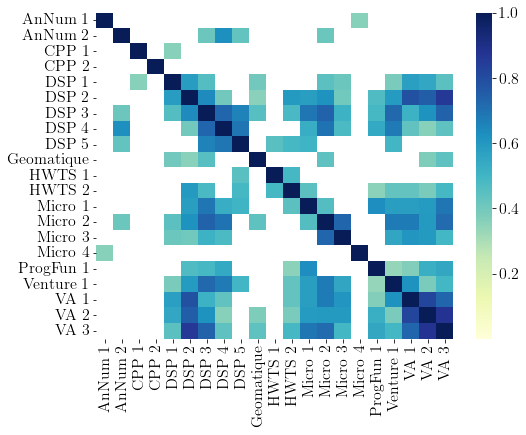

In [18]:
d_fail = get_spearmans_plot(df_fail, [dict_course_names[i] for i in best_unit.keys()], "../images/unit/over_all_worst.jpeg")

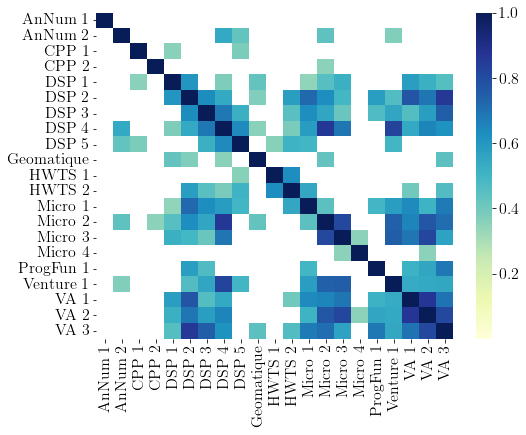

In [19]:
d_pass = get_spearmans_plot(df_pass, [dict_course_names[i] for i in best_unit.keys()],  "../images/unit/over_all_best.jpeg")

In [20]:
for i in range(len(d_fail)):
    for k,j in enumerate(d_fail.columns):
        if d_fail[j][i] == -1:
            d_fail[j][i] = 0

In [21]:
for i in range(len(d_pass)):
    for k,j in enumerate(d_pass.columns):
        if d_pass[j][i] == -1:
            d_pass[j][i] = 0

In [22]:
cols = [dict_course_names[i] for i in best_unit.keys()]

### Difference 

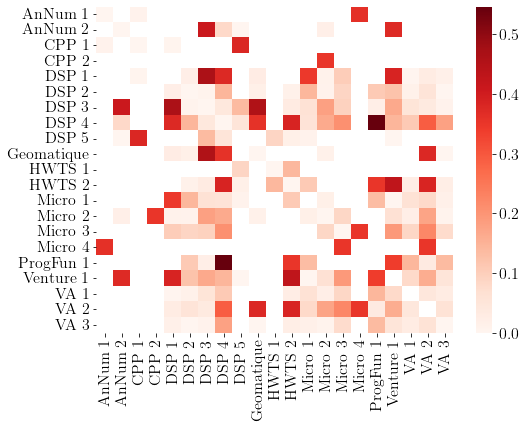

In [23]:
zero_data = np.zeros(shape=(21, 21))
d = pd.DataFrame(zero_data, columns=cols)

for i in range(len(d_pass)):
    for k,j in enumerate(d_pass.columns):
        d[j][i] = np.abs(d_pass[j][i]-d_fail[j][i])
        if d[j][i] == 0:
            d[j][i] = -1

my_cmap = copy(plt.cm.Reds)
my_cmap.set_over("white")
my_cmap.set_under("white")

fig, ax = plt.subplots(figsize=(8, 6),facecolor='white')
g = sns.heatmap(d, vmin=0, fmt=".2f",ax=ax, cmap=my_cmap)
l=list(np.arange(1,6+1))
g.xaxis.get_label().set_fontsize(14)
g.yaxis.get_label().set_fontsize(14)
g.set_xticklabels(cols,rotation=90, fontsize=16)
g.set_yticklabels(cols, rotation=0, fontsize=16)

cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=16)

plt.savefig("../images/unit/over_all_diff.jpeg", bbox_inches='tight')
plt.show()

## Metadata Analysis

In [24]:
def plot_metadata(funct, df, fname):
    labels_in_order = []
    for c in best_unit.keys():
        labels_in_order.append(funct[c])
    
    df['labels'] = labels_in_order
    df = df.fillna(0)
    
    x = df.groupby('labels').mean().reset_index()
    
    labels = x['labels']

    x = x.drop('labels', axis=1)

    get_spearmans_plot(x, labels.tolist(), fname)
    
    return x

In [25]:
def sub_analyses_plots(df, type_):
    topics_df = plot_metadata(topics_course, df, "../images/unit/"+type_+"_topics_heatmap.pdf")
    quizzes_df = plot_metadata(no_quizzes_course, df, "../images/unit/"+type_+"_n_quizzes_heatmap.pdf")
    language_level_df = plot_metadata(language_and_level_course, df, "../images/unit/"+type_+"_lang_level_heatmap.pdf")
    weeks_df = plot_metadata(no_weeks_course, df, "../images/unit/"+type_+"_n_weeks_heatmap.pdf")
    return topics_df, quizzes_df, language_level_df
    

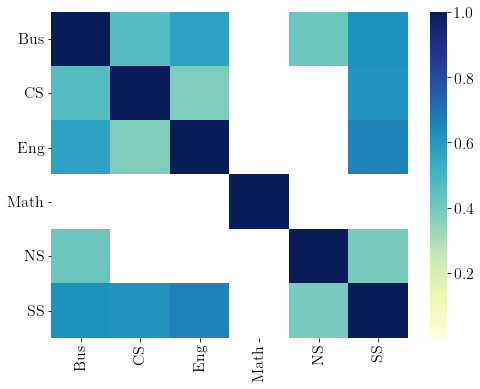

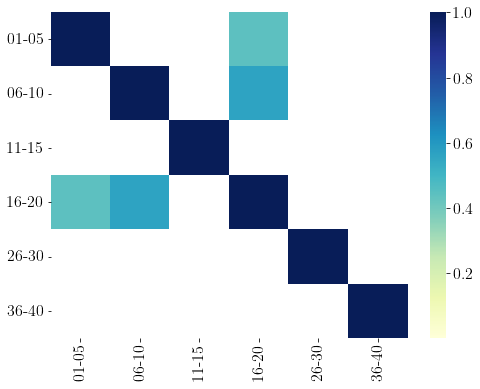

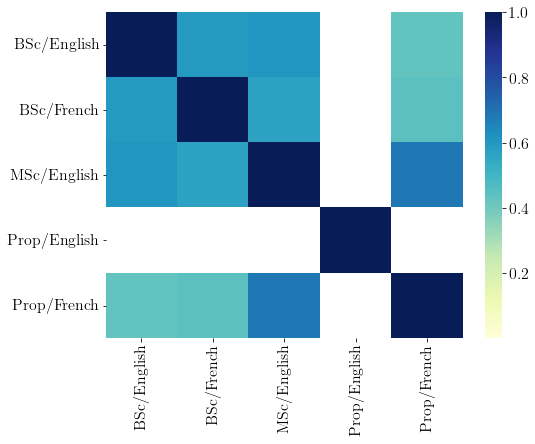

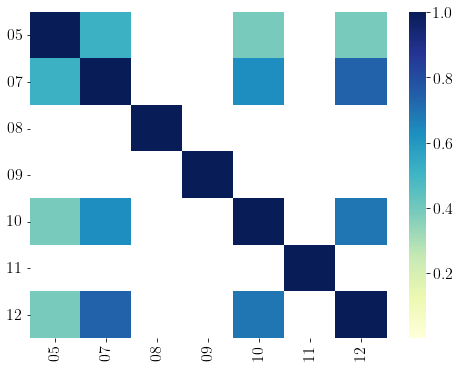

In [26]:
topics_df, quizzes_df, language_level_df = sub_analyses_plots(df_fail, 'worst')

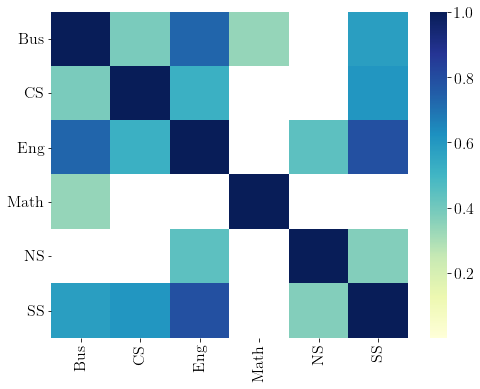

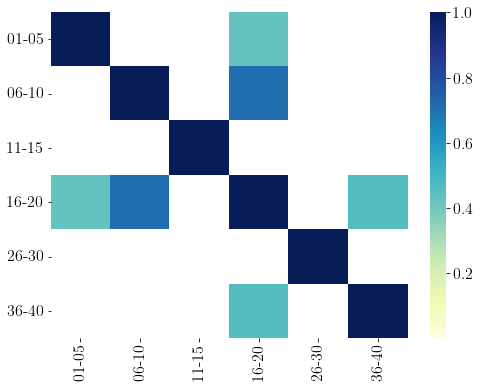

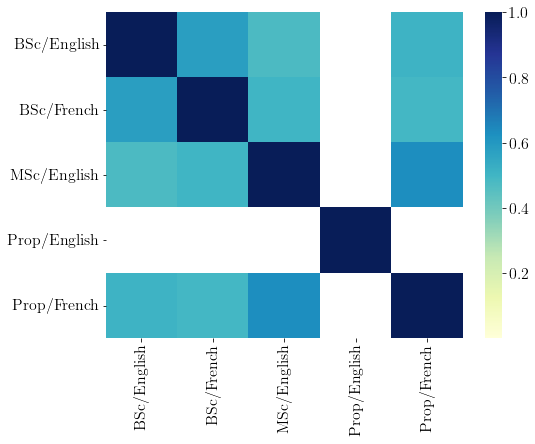

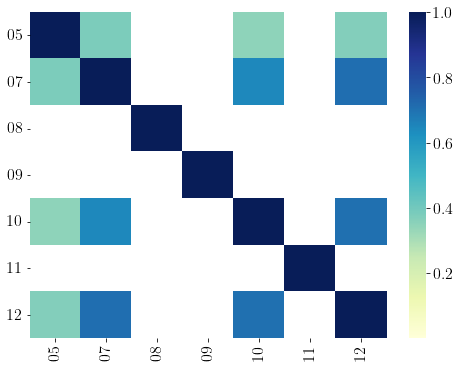

In [27]:
topics_df2, quizzes_df, language_level_df = sub_analyses_plots(df_pass, 'best')

## PCA Analysis

In [28]:
df_importance = df_importance.fillna(0)

In [29]:
pca2 = PCA(n_components=2)
PCA2 = pca2.fit_transform(df_importance)
dfpca = pd.DataFrame(PCA2)
dfpca['cluster'] = labels_in_order
dfpca.columns = ['x1','x2','cluster']

In [30]:
pca2.explained_variance_ratio_

array([0.1807248 , 0.16043664])

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


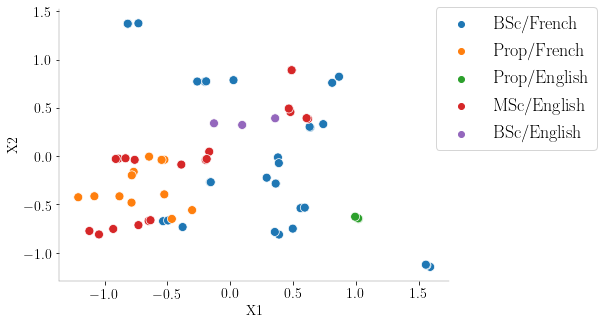

In [31]:
def plot_scatterplot(data, hue):
    plt.figure(figsize=(7,5))
    sns.scatterplot(data=data,x='x1',y='x2',hue=hue,legend="full",alpha=1, s=80)
    plt.legend(loc='upper right', bbox_to_anchor=(1.4, 1.04), fontsize=18)
    plt.tick_params(labelsize=14)
    plt.ylabel('X2',fontsize=14)
    plt.xlabel('X1',fontsize=14)

    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['left'].set_visible(True)
    plt.gca().spines['bottom'].set_visible(True)

    plt.gca().spines['left'].set_linewidth(0.4)
    plt.gca().spines['bottom'].set_linewidth(0.4)

    plt.gca().spines['left'].set_color('grey')
    plt.gca().spines['bottom'].set_color('grey')

    plt.savefig("../images/unit/pca_all_clusters.pdf", bbox_inches='tight')
    plt.show()

plot_scatterplot(dfpca, lang_in_order)

## Statistical Analysis

In [32]:
df_importance, labels_in_order, fields_in_order, lang_in_order = get_feature_importance_all_clusters()

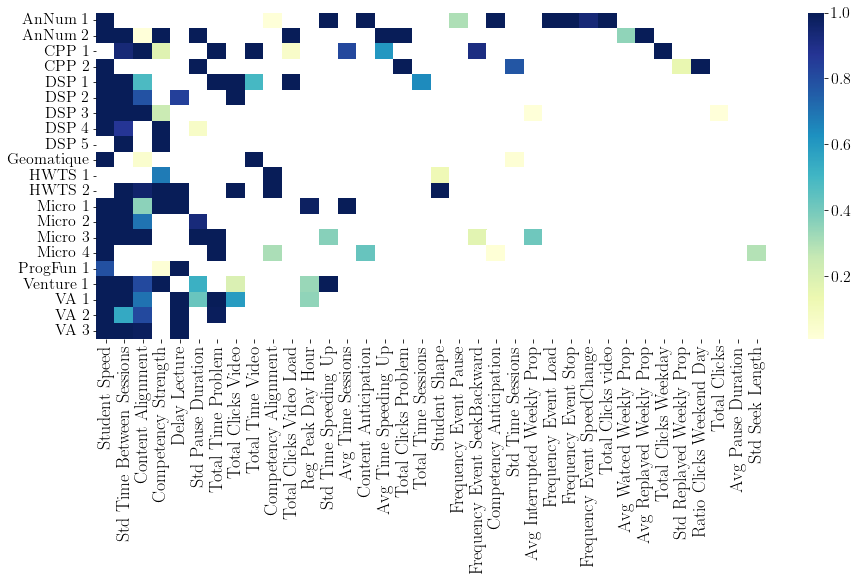

In [33]:
d = get_all_features_per_course('../images/new/features-all-courses.pdf', order_feats)

In [34]:
levels = []
for c in df_selected['course']:
    levels.append(level_course[c])
    
lang = []
for c in df_selected['course']:
    lang.append(language_course[c])
    
fields = []
for c in df_selected['course']:
    fields.append(topics_course[c])

In [35]:
d['Fields'] = fields

In [36]:
from scipy.stats import shapiro, levene
import numpy as np


normality_results = {}
homogeneity_results = {}


columns_to_test = take(10, order_feats)
print(columns_to_test)

for column in columns_to_test:
    # 1. Test for Normality
    cg_values = d[d['Fields'] == 'Math'][column].dropna()
    tg1_values = d[d['Fields'] == 'CS'][column].dropna()
    tg2_values = d[d['Fields'] == 'Eng'][column].dropna()
    tg3_values = d[d['Fields'] == 'SS'][column].dropna()
    

    _, p_cg = shapiro(cg_values)
    _, p_tg1 = shapiro(tg1_values)
    _, p_tg2 = shapiro(tg2_values)
    _, p_tg3 = shapiro(tg3_values)
    combined_p = np.min([p_cg, p_tg1, p_tg2, p_tg3])  
    
    normality_results[column] = combined_p
    
    # 2. Test for Homogeneity of Variance
    _, p_lev = levene(cg_values, tg1_values, tg2_values, tg3_values)
    homogeneity_results[column] = p_lev


normality_df = pd.DataFrame(list(normality_results.items()), columns=['Feature', 'P-value (Normality)'])
homogeneity_df = pd.DataFrame(list(homogeneity_results.items()), columns=['Feature', 'P-value (Homogeneity)'])
assumptions_df = pd.merge(normality_df, homogeneity_df, on='Feature')

assumptions_df.head(10)

['Student Speed', 'Std Time Between Sessions', 'Content Alignment', 'Competency Strength', 'Delay Lecture', 'Std Pause Duration', 'Total Time Problem', 'Total Clicks Video', 'Total Time Video', 'Competency Alignment']


/home/isadorasalles/anaconda3/lib/python3.7/site-packages/scipy/stats/morestats.py:1673: UserWarning:

Input data for shapiro has range zero. The results may not be accurate.

/home/isadorasalles/anaconda3/lib/python3.7/site-packages/scipy/stats/morestats.py:1673: UserWarning:

Input data for shapiro has range zero. The results may not be accurate.

/home/isadorasalles/anaconda3/lib/python3.7/site-packages/scipy/stats/morestats.py:1673: UserWarning:

Input data for shapiro has range zero. The results may not be accurate.

/home/isadorasalles/anaconda3/lib/python3.7/site-packages/scipy/stats/morestats.py:1673: UserWarning:

Input data for shapiro has range zero. The results may not be accurate.

/home/isadorasalles/anaconda3/lib/python3.7/site-packages/scipy/stats/morestats.py:1673: UserWarning:

Input data for shapiro has range zero. The results may not be accurate.

/home/isadorasalles/anaconda3/lib/python3.7/site-packages/scipy/stats/morestats.py:1673: UserWarning:

Input data for sh

,Feature,P-value (Normality),P-value (Homogeneity)
0,Student Speed,4.549987e-04,0.381877
1,Std Time Between Sessions,-9.106917e-07,0.964785
2,Content Alignment,1.715880e-02,0.029136
3,Competency Strength,-9.106917e-07,0.721117
4,Delay Lecture,1.329634e-04,0.675991
5,Std Pause Duration,-9.106917e-07,0.390656
6,Total Time Problem,6.322972e-05,0.436161
7,Total Clicks Video,-9.106917e-07,0.596889
8,Total Time Video,-9.106917e-07,0.532792
9,Competency Alignment,-9.106917e-07,0.352950


In [37]:
from scipy.stats import f_oneway, kruskal
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scikit_posthocs import posthoc_dunn


test_results = {"Feature": [], "Test Used": [], "P-value": [], "Significant": []}
post_hoc_results = {"Feature": [], "Group1": [], "Group2": [], "P-value": [], "Significant": []}


for column in columns_to_test:
    cg_values = d[d['Fields'] == 'Math'][column].dropna()
    tg1_values = d[d['Fields'] == 'CS'][column].dropna()
    tg2_values = d[d['Fields'] == 'Eng'][column].dropna()
    tg3_values = d[d['Fields'] == 'SS'][column].dropna()

    
    if (normality_results[column] > 0.05) and (homogeneity_results[column] > 0.05):
        _, p_val = f_oneway(cg_values, tg1_values, tg2_values, tg3_values)
        test_results["Test Used"].append("ANOVA")
    else:
        _, p_val = kruskal(cg_values, tg1_values, tg2_values, tg3_values)
        test_results["Test Used"].append("Kruskal-Wallis")

    test_results["Feature"].append(column)
    test_results["P-value"].append(p_val)
    test_results["Significant"].append(p_val < 0.05)

test_results_df = pd.DataFrame(test_results)
post_hoc_df = pd.DataFrame(post_hoc_results)

test_results_df.head(10), post_hoc_df.head(10)

(                     Feature       Test Used   P-value  Significant
 0              Student Speed  Kruskal-Wallis  0.238791        False
 1  Std Time Between Sessions  Kruskal-Wallis  0.682572        False
 2          Content Alignment  Kruskal-Wallis  0.347078        False
 3        Competency Strength  Kruskal-Wallis  0.398006        False
 4              Delay Lecture  Kruskal-Wallis  0.046892         True
 5         Std Pause Duration  Kruskal-Wallis  0.759880        False
 6         Total Time Problem  Kruskal-Wallis  0.389981        False
 7         Total Clicks Video  Kruskal-Wallis  0.784298        False
 8           Total Time Video  Kruskal-Wallis  0.385851        False
 9       Competency Alignment  Kruskal-Wallis  0.338005        False,
 Empty DataFrame
 Columns: [Feature, Group1, Group2, P-value, Significant]
 Index: [])

In [38]:
a = pd.DataFrame({'values':d['Delay Lecture'], 'group':d['Fields']})
res_dunn = posthoc_dunn(a, val_col='values', group_col='group', p_adjust=None, sort=True)
print(res_dunn)

           Bus        CS       Eng      Math        NS        SS
Bus   1.000000  0.558719  0.630182  1.000000  0.379379  0.062219
CS    0.558719  1.000000  0.893587  0.359604  0.563746  0.023551
Eng   0.630182  0.893587  1.000000  0.480934  0.534221  0.034481
Math  1.000000  0.359604  0.480934  1.000000  0.238256  0.008361
NS    0.379379  0.563746  0.534221  0.238256  1.000000  0.238256
SS    0.062219  0.023551  0.034481  0.008361  0.238256  1.000000


In [39]:
passing_rate = {}
for course in df_selected['course']:
    path = data_path + course + '/'
    hard_fails = pd.read_csv(f'{path}/eq_week-marras_et_al-{course}/feature_labels.csv', index_col=0)
    hard_fail_idx = hard_fails.index.tolist()
    labels = hard_fails['label-pass-fail'].values
    passing_rate[course] = len(np.where(labels == 0)[0])/len(labels)

### Correlation of feature value and passing rate (top 10 features)

In [40]:
df = pd.DataFrame()
df['Features'] = columns_to_test
corr = []
p_value = []
for column in columns_to_test:
    corr.append(stats.spearmanr(d[column], list(passing_rate.values()))[0])
    p_value.append(stats.spearmanr(d[column], list(passing_rate.values()))[1])
df['Correlation'] = corr
df['P-value'] = p_value

In [41]:
df

,Features,Correlation,P-value
0,Student Speed,-0.360104,0.108827
1,Std Time Between Sessions,-0.327709,0.147003
2,Content Alignment,-0.535394,0.012378
3,Competency Strength,0.310972,0.170034
4,Delay Lecture,-0.009053,0.968934
5,Std Pause Duration,-0.279875,0.219165
6,Total Time Problem,-0.371743,0.097053
7,Total Clicks Video,-0.035889,0.877259
8,Total Time Video,0.247349,0.279697
9,Competency Alignment,0.237872,0.299121


In [42]:
n_quizzes = []
for course in df_selected['course']:
    n_quizzes.append(no_quizzes_course_int[course])
    
n_weeks = []
for course in df_selected['course']:
    n_weeks.append(no_weeks_course_int[course])

### Correlation of feature value and number of quizzes (top 10 features)

In [43]:
df = pd.DataFrame()
df['Features'] = columns_to_test
corr = []
p_value = []
for column in columns_to_test:
    corr.append(stats.spearmanr(d[column], n_quizzes)[0])
    p_value.append(stats.spearmanr(d[column], n_quizzes)[1])
df['Correlation'] = corr
df['P-value'] = p_value

In [44]:
df

,Features,Correlation,P-value
0,Student Speed,0.468902,0.032015
1,Std Time Between Sessions,0.320726,0.156329
2,Content Alignment,-0.041234,0.859144
3,Competency Strength,-0.042855,0.853664
4,Delay Lecture,-0.206234,0.369768
5,Std Pause Duration,-0.067319,0.771866
6,Total Time Problem,-0.069311,0.765298
7,Total Clicks Video,0.047783,0.837043
8,Total Time Video,-0.052595,0.820876
9,Competency Alignment,-0.299013,0.187935


### Correlation of feature value and number of weeks (top 10 features)

In [45]:
df = pd.DataFrame()
df['Features'] = columns_to_test
corr = []
p_value = []
for column in columns_to_test:
    corr.append(stats.spearmanr(d[column], n_weeks)[0])
    p_value.append(stats.spearmanr(d[column], n_weeks)[1])
df['Correlation'] = corr
df['P-value'] = p_value

In [46]:
df

,Features,Correlation,P-value
0,Student Speed,0.444668,0.043413
1,Std Time Between Sessions,0.120677,0.602324
2,Content Alignment,0.364630,0.104131
3,Competency Strength,-0.459670,0.036041
4,Delay Lecture,0.247728,0.278939
5,Std Pause Duration,-0.030800,0.894562
6,Total Time Problem,0.413618,0.062344
7,Total Clicks Video,-0.075292,0.745661
8,Total Time Video,0.118148,0.610009
9,Competency Alignment,-0.490690,0.023912


### Correlation between worst and best clusters

In [54]:
df_fail = df_fail.drop(['labels'], axis=1)
df_pass = df_pass.drop(['labels'], axis=1)

In [55]:
df_fail = df_fail.fillna(0)
df_pass = df_pass.fillna(0)

In [56]:
aux = pd.concat([df_fail, df_pass])

In [57]:
aux = aux.reset_index()

In [58]:
aux = aux.fillna(0)

In [59]:
aux

,index,frequency_action_Video.Load,frequency_action_Video.Pause,frequency_action_Video.Stop,frequency_action_Video.SpeedChange,time_speeding_up std,total_clicks_video,competency_alignment,competency_anticipation,content_anticipation,...,ratio_clicks_weekend_day,total_clicks_Video,time_sessions sum,delay_lecture,student_shape,regularity_peak_dayhour,weekly_prop_interrupted mean,seek_length std,total_clicks,pause_duration mean
0,0,1.0,0.075829,1.0,0.909953,1.000000,0.995261,0.004739,0.981043,1.000000,...,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
2,2,0.0,0.022727,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
3,3,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
4,4,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,1.000000,0.515173,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
5,5,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,1.000000,0.000000,0.994186,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
6,6,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
7,7,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
8,8,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
9,9,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000


In [60]:
df = pd.DataFrame()
c = []
corr = []
p_value = []
for i, course in enumerate(df_selected['course']):
    c.append(dict_course_names[course])
    corr.append(stats.spearmanr(aux.iloc[i], aux.iloc[i+len(df_fail)])[0])
    p_value.append(stats.spearmanr(aux.iloc[i], aux.iloc[i+len(df_fail)])[1])

df['Course'] = c
df['Correlation'] = corr
df['P-value'] = p_value

In [61]:
df

,Course,Correlation,P-value
0,AnNum 1,0.993755,6.247010e-35
1,AnNum 2,1.000000,0.000000e+00
2,CPP 1,0.928281,1.322218e-16
3,CPP 2,1.000000,0.000000e+00
4,DSP 1,0.998740,4.434965e-47
5,DSP 2,0.999424,5.020611e-53
6,DSP 3,0.825043,3.377298e-10
7,DSP 4,0.925354,2.600851e-16
8,DSP 5,1.000000,0.000000e+00
9,Geomatique,0.817221,6.794606e-10


In [62]:
np.mean(df['Correlation'])

0.9443761408412915